## Formal Image Renderer
Render each hanzi character, image size is "roughly" 1000x1000 

(1111, 1200)


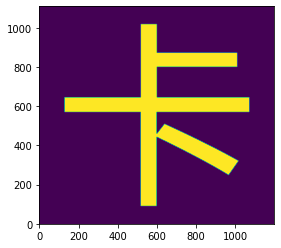

In [9]:
import matplotlib.pyplot as plt
import numpy as np

import FormalImage as fi

character = '卡'

charImg = fi.renderChar(character, show=True, fontsize=1000)
print(np.shape(charImg))

## Hand Written Image Renderer
Since we're using the hanzi writer data to figure out general stroke type we need to have a renderer for drawing using that data

[[[470, 516, 510, 493], [813, 773, 519, 498]], [[547, 566, 605, 704, 753], [662, 654, 656, 682, 684]], [[128, 186, 424, 806, 850, 914], [438, 428, 464, 502, 499, 480]], [[480, 510, 497, 510], [448, 419, 52, -29]], [[577, 682, 706, 724], [350, 298, 273, 241]]]
(-113.0, 897.0)


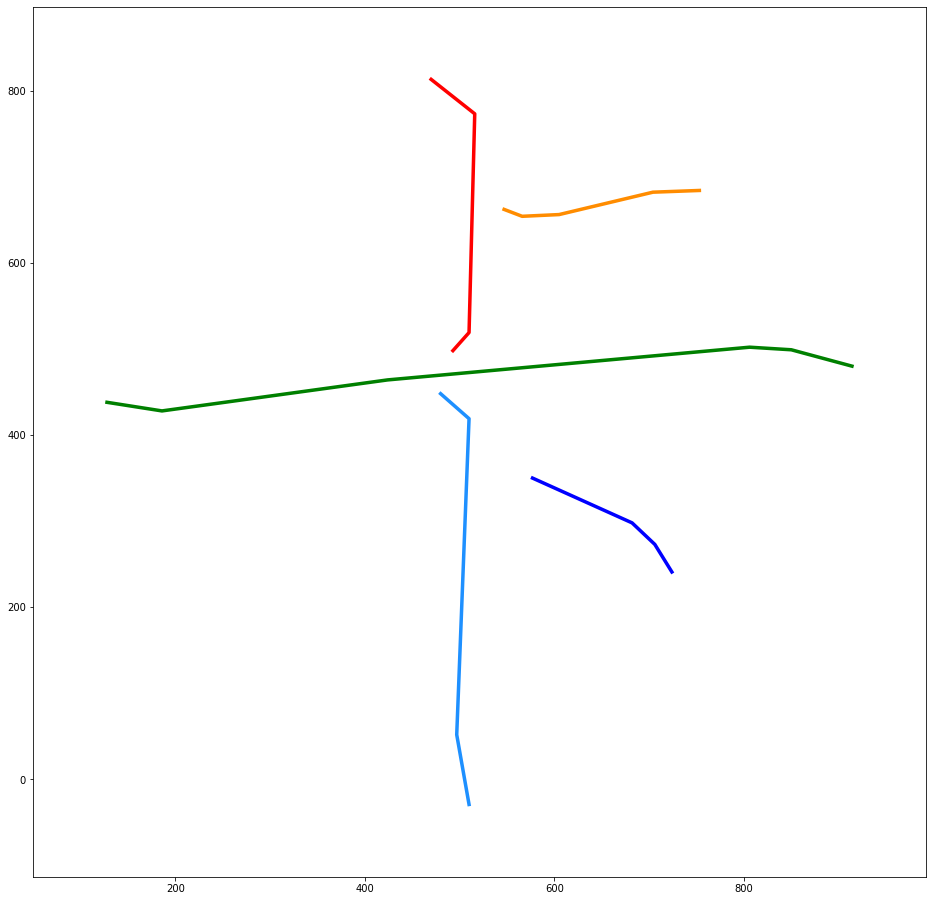

In [10]:
import matplotlib.pyplot as plt
import numpy as np

import HandImage as wi

strokeData = wi.getStrokeData(character)
print(strokeData)
fig, ax = wi.plotChar(character)
#plt.show()

print(ax.get_ylim())

## Hand Strokes & Formal Strokes
To match stroke types for the hanzi writer we need a stroke definition for each type. See https://en.wikipedia.org/wiki/Stroke_(CJK_character) (maybe we need more/less)?
Since we're ending up with the formal image type we need a stroke definition for each type.
Then when fitting the stroke we fit with the handwritten type and then just translate to the corresponding formal type.

A stroke definition should be as follows. List of control point coordinates [x,y] for a bezier curve such that the stroke is bounded a box from [0,0] to [1,1] 

Probably easiest to store strokes as JSON files, but lots of formats could work.

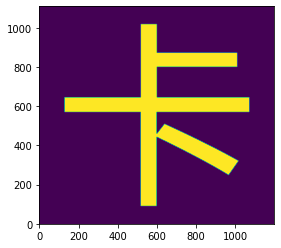

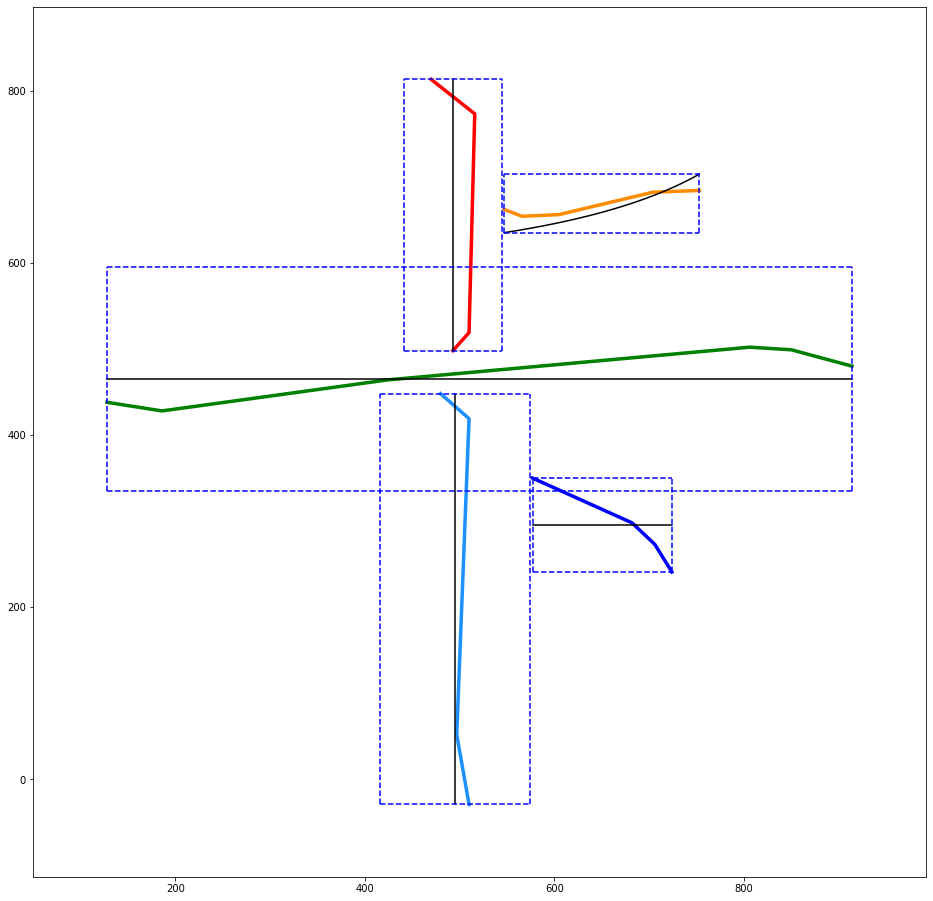

In [11]:
import Strokes as st
import HandImage as wi
import FormalImage as fi
import numpy as np
import matplotlib.pyplot as plt

#character = '\u4e0a'

charImg = fi.renderChar(character, show=True, fontsize=1000)

strokeData = wi.getStrokeData(character)
#print(strokeData)
fig, ax = wi.plotChar(character)

handFits = st.fitStrokes(strokeData)
#needs some work
handBounds = [ax.get_xlim(), ax.get_ylim()]
formalBounds = [[0,np.shape(charImg)[1]], [0,np.shape(charImg)[0]]]
formalFits = st.translateFits(handFits, handBounds, formalBounds)

ax = st.plotHandFits(handFits, ax=ax, drawBox=True)

0.0


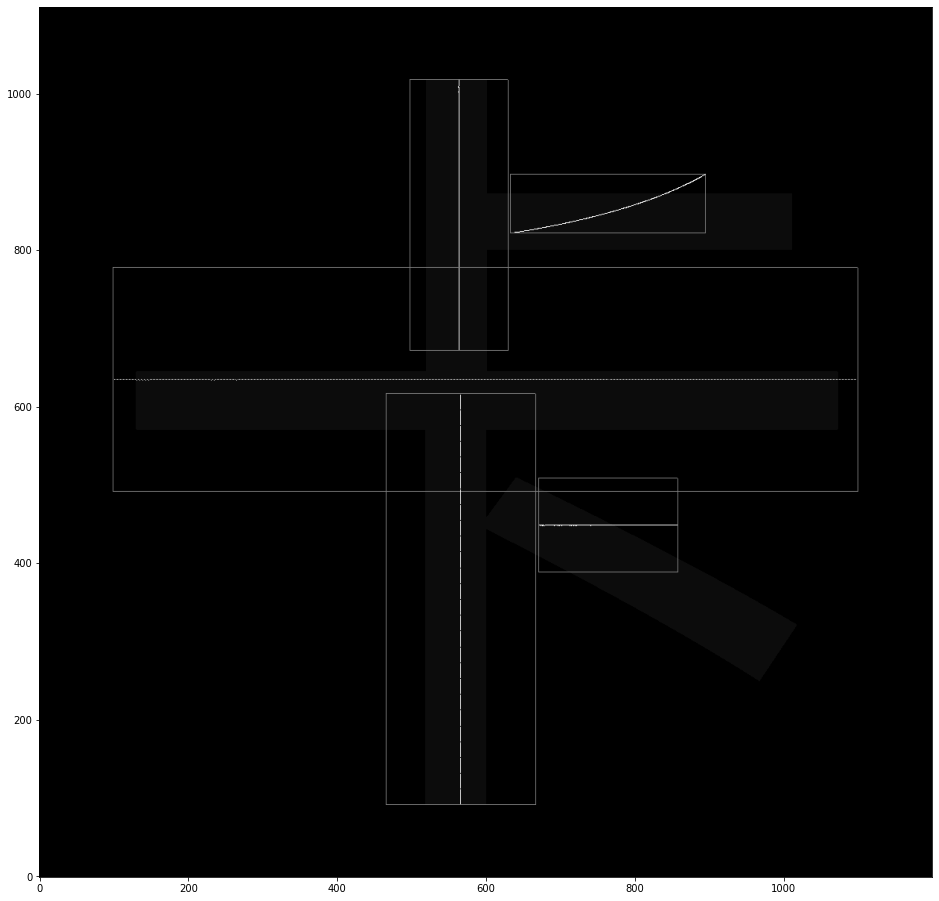

In [12]:
from matplotlib import colors
formalFitImg = st.drawFormalFits(formalFits, charImg)

fig, ax = plt.subplots(figsize=(16,16))

ax.imshow(formalFitImg, origin='lower', cmap='gray', vmin=0, vmax=20, aspect='auto')

print(np.min(formalFitImg))

## Adjusting Formal Strokes
Since the geometry for the formal strokes is all over the place we need to move each fitted stroke to the "best position". Not too sure how manual this process will have to be.

Automated ideas:
1. Gravity simulation to pull each fit into position? (expensive)
2. Gradient descent and drag bound to minimize error (only 4 variables, what is the error function: total bound movement + border leeway (penalize points that are close/touching whitespace, also maybe larger bound boxes are best?)

Additionally sometimes it's likely that some characters are rendered too differently they'll need to be manually fixed, so we'll need some editor.

In [13]:
#helper function for creating distance image
#masks are the centered square, sub are the directional squares that we are modifying based on the masks
def findMask(distMask, setMask, distSub, setSub):
    #setMask is set and either the pixel isn't set or this mask is better 
    return (setMask==1) & ( (setSub == 0) | (distMask + 1 < distSub) )

def generateDistImage(distMatr, setMatr):
    while(np.min(setMatr[1:-1,1:-1]) == 0): #still unset pixels (ignoring border)
        distMask = distMatr[1:-1, 1:-1]
        isSetMask = setMatr[1:-1, 1:-1]

        #each direction mask: pixel isn't set, but shifted mask is)
        upMask = findMask(distMask, isSetMask, distMatr[:-2,1:-1], setMatr[:-2,1:-1])
        distMatr[:-2,1:-1][upMask] = distMask[upMask] + 1
        setMatr[:-2,1:-1][upMask] = 1

        downMask = findMask(distMask, isSetMask, distMatr[2:,1:-1], setMatr[2:,1:-1])
        distMatr[2:,1:-1][downMask] = distMask[downMask] + 1
        setMatr[2:,1:-1][downMask] = 1

        leftMask = findMask(distMask, isSetMask, distMatr[1:-1,:-2], setMatr[1:-1,:-2])
        distMatr[1:-1,:-2][leftMask] = distMask[leftMask] + 1
        setMatr[1:-1,:-2][leftMask] = 1

        rightMask = findMask(distMask, isSetMask, distMatr[1:-1,2:], setMatr[1:-1,2:])
        distMatr[1:-1,2:][rightMask] = distMask[rightMask] + 1
        setMatr[1:-1,2:][rightMask] = 1
        
    return distMatr

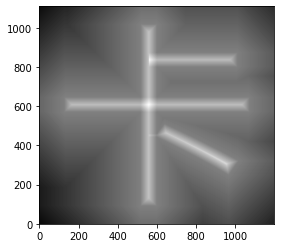

In [14]:
#generate distance each pixel is from edge (e.g. 0 is not on the character, and 12 would be 12 steps away)
distImgPos = charImg.copy() #how far each pixel is from whitespace
distImgNeg = charImg.copy() #how far each pixel is from blackspace
setImgPos = np.zeros(np.shape(charImg)) #tracks which pixels we have the distance set for, 1: set, 0: unset
setImgNeg = np.zeros(np.shape(charImg))

setImgPos[charImg == 0] = 1 #initial white-space pixels 
distImgPos[charImg == 0] = 0 #white is zero distance
setImgNeg[charImg == 1] = 1 #initial black-space pixels 
distImgNeg[charImg == 1] = 0 #black is zero distance

distImgPos = generateDistImage(distImgPos, setImgPos)
distImgNeg = generateDistImage(distImgNeg, setImgNeg)

#not quite sure what the weightings should be, listed a couple options
distImg = distImgPos/np.max(distImgPos) - distImgNeg/np.max(distImgNeg) #normalizing
#distImg = distImgPos - distImgNeg #simplest
#distImg = 5*distImgPos - distImgNeg #weight positive more, nearly the same as the normalization one

plt.imshow(distImg, origin='lower', cmap='gray')
#plt.imshow(setImg, origin='lower')

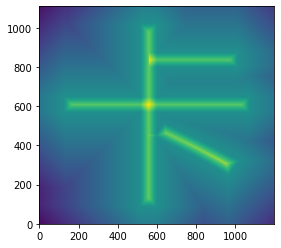

In [15]:
distImg = distImgPos/np.max(distImgPos) - distImgNeg/np.max(distImgNeg) #normalizing
plt.imshow(distImg, origin='lower')

## Trying out gradiant descent to fit:
Maximize some function combining the following elements:
- Perimeter of the bounding box
- Distance of bounding box from original bounding box
- Distance of line fit from whitespace (see distance image)
- Aspect Ratio

In [85]:
import bezier
import numpy as np
import matplotlib.pyplot as plt
import random
import scipy.optimize as opt

#params (and origBounds) are in format of params = [left, right, down, up]
#weights (and ranges): [perimeter [0,10], distance of bounds [0,10], point score [0,10],
#    aspectRatio [0,10] ] 
#stroke should just be straight from the dictionary
def errFunc(params, origBounds, stroke, strokeType, distImg, weights):
    #basic check bounds make sense (min < max)
    height = len(distImg)
    width = len(distImg[0])
    if(params[1] <= params[0] or params[3] <= params[2]):
        return 10e10 #super big error
    #python allows this kind of comparison
    if( not ((0 <= params[0] < width) and (0 <= params[1] < width)) ):
        return 10e10 #super big error
    if( not ((0 <= params[2] < height) and (0 <= params[3] < height)) ):
        return 10e10 #super big error
    if( (params[1] - params[0]) < 100 or (params[3] - params[2]) < 100): #stroke is far too small
        return 10e10
    
    #now for actual error calculating
    #calculate bounding box perimeter
    perim = 2*(params[1] - params[0]) + 2*(params[3] - params[2])
    origPerim = 2*(origBounds[1] - origBounds[0]) + 2*(origBounds[3] - origBounds[2])
    perimRatio = (perim/origPerim)
    
    #calculate bounds (just sum of the 4 distances)
    boundError = sum(abs(params-origBounds)) / (height+width)
    
    #calculate point error
    #grab a bunch of sample of the bezier curve and sum their distImg scores
    pointScore = 0
    evalPoints = np.linspace(0.0, 1.0, 500) #how many samples from bezier curve
    for curve in stroke:
        curve = np.array(curve)
        curve[:,0] = params[0] + (curve[:,0]*(params[1] - params[0]))
        curve[:,1] = params[2] + (curve[:,1]*(params[3] - params[2]))
        
        nodes = np.array(curve).transpose()
        curve = bezier.Curve(nodes, degree=len(curve)-1)
        curvePoints = np.array(curve.evaluate_multi(evalPoints).transpose().tolist()) #[[x,y],...]
        curvePoints = np.unique(curvePoints.astype(int),axis=0)
        for p in curvePoints:
            pointScore += distImg[p[1],p[0]]
    
    #aspect ratio, difference between new and original
    if(strokeType == 'd0' or strokeType == 'd1'): #horizontal or vertical line ratio doesn't matter
        skew = 0
    else:
        oR = (origBounds[3]-origBounds[2])/(origBounds[1]-origBounds[0]) #original height/width
        nR = (params[3]-params[2])/(params[1]-params[0]) #new height/width
        skew = abs(nR - oR) #0 is best
        
    #since we're minimizing, area is good and so are close points, so make them negative.
    return -weights[0]*perimRatio + weights[1]*boundError - weights[2]*pointScore + weights[3]*skew


def randomBound(shape, origBounds): #shape: (height, width)
    origShape = [origBounds[3]-origBounds[2], origBounds[1]-origBounds[0]] #[height, width]
    #see: https://www.desmos.com/calculator/okgyxao4ha to determine box height/width
    randNums = (np.random.rand(2)*2)-1 #[-1, 1]
    newShape = np.zeros(2) #[height, width]
    for i in range(2):
        if(randNums[i] <= 0):
            scale = 1-randNums[i]
        else: #pos
            scale = 1/(1-randNums[i])
        newShape[i] = int(scale*origShape[i])
        if(newShape[i] >= shape[i]): #make sure bound isn't too big
            newShape[i] = shape[i]-1
    
    bLCoord = np.floor(np.random.rand(2)*(shape - newShape)) #bottom Left coordinates
    return [bLCoord[1], bLCoord[1]+newShape[1], bLCoord[0], bLCoord[0]+newShape[0]]
    
#perim, bound diff, distance score, aspect ratio
def findBestFit(origFit, formalDict, distImg, weights=[1,1,1,1], iters=100):
    
    stroke = formalDict[origFit.type]
    strokeType = origFit.type
    b = origFit.bounds
    origBounds = np.array([b.minX, b.maxX, b.minY, b.maxY])
    imgShape = np.shape(distImg)
    
    bestError = 10e10 #arbitrary high value
    bestFit = [0,0,100,100]
    for i in range(iters):
        params = randomBound(imgShape, origBounds)
        sol = opt.minimize(errFunc, params, (origBounds, stroke, strokeType, distImg, weights), 
                       tol = 10e-7, method='Nelder-Mead')['x']
        err = errFunc(params, origBounds, stroke, strokeType, distImg, weights)
        if(err < bestError):
            print(i, err, sol)
            bestError = err
            bestFit = sol
    
    sol = bestFit.astype(int)
    fit = st.StrokeMatch(origFit.type, origFit.style, st.BoundingBox([[sol[0],sol[1]],[sol[2],sol[3]]]))   
    return fit, bestError

0 630.4712014968351 [2.91344301e+02 8.32655698e+02 7.50396559e-04 9.85074065e+02]
1 430.1722485745909 [  2.9621593  630.00046684 562.9916744  662.99220997]
2 -627.0099407744093 [  71.44392781 1052.55606275  480.81040753  979.99999695]
44 -985.9377864610125 [312.8446895  809.15531051 361.21406893 864.99674906]
<Strokes.BoundingBox object at 0x000001C5E98E6F70> -985.9377864610125
0 289.95529137531304 [183.05989206 550.11923731 574.01890174 675.30589569]
1 -111.37949168459329 [454.12611808 591.19249986 580.12050793 872.02112633]
24 -274.7439643477609 [ 524.42422461 1086.99518089  582.9139873   682.96736775]
57 -377.24001721703195 [ 525.55650621 1058.57053097  578.06910113  678.19979878]
<Strokes.BoundingBox object at 0x000001C583851BB0> -377.24001721703195
0 187.8257274425322 [6.76248852e-04 1.03769380e+03 4.29348904e+02 7.86651136e+02]
1 172.3580966276347 [5.66572135e-04 8.05647821e+02 2.94887553e+02 6.11112425e+02]
4 151.943538260447 [   4.88250539 1042.94953908  291.86265285  926.13734

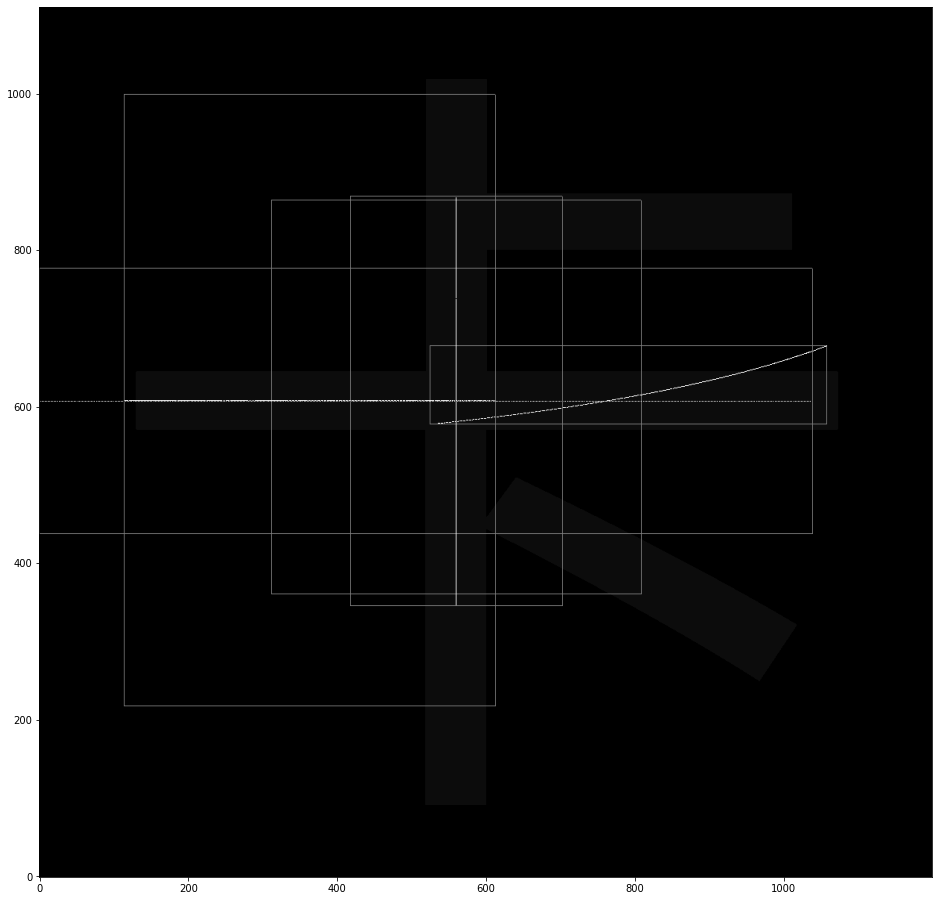

In [92]:
import Strokes as st

formalDict = st.loadFormalStrokes()

weights = [2,10,4,5] #perim, bound diff, distance score, aspect ratio
iters = 100

newFormalFits = []
for fit in formalFits:
    newFit, error = findBestFit(fit, formalDict, distImg, weights = weights, iters = iters)
    newFormalFits.append(newFit)
    print(newFit.bounds, error)
    
newFitImg = st.drawFormalFits(newFormalFits, charImg, drawBox=True)
fig, ax = plt.subplots(figsize=(16,16))
ax.imshow(newFitImg, origin='lower', cmap='gray', vmin=0, vmax=20, aspect='auto')

[ 498  630  672 1018]
[427.33559564 694.66440544 447.42607217 952.97632828] -878.1392405063318
[633 895 822 897]
[ 543.28691256 1041.7348833   804.25447275  904.45388324] 100000000000.0
[  99 1100  492  778]
[138.999989   640.16956603 465.4657114  752.5189782 ] -377.85837998088857
[466 667  92 617]
[  18.49884361 1103.50115468  161.13278857  662.83984475] -1139.3417721518942
[671 858 389 509]
[519.99996279 814.00988506 313.98979874 544.0100168 ] -167.82990384427845


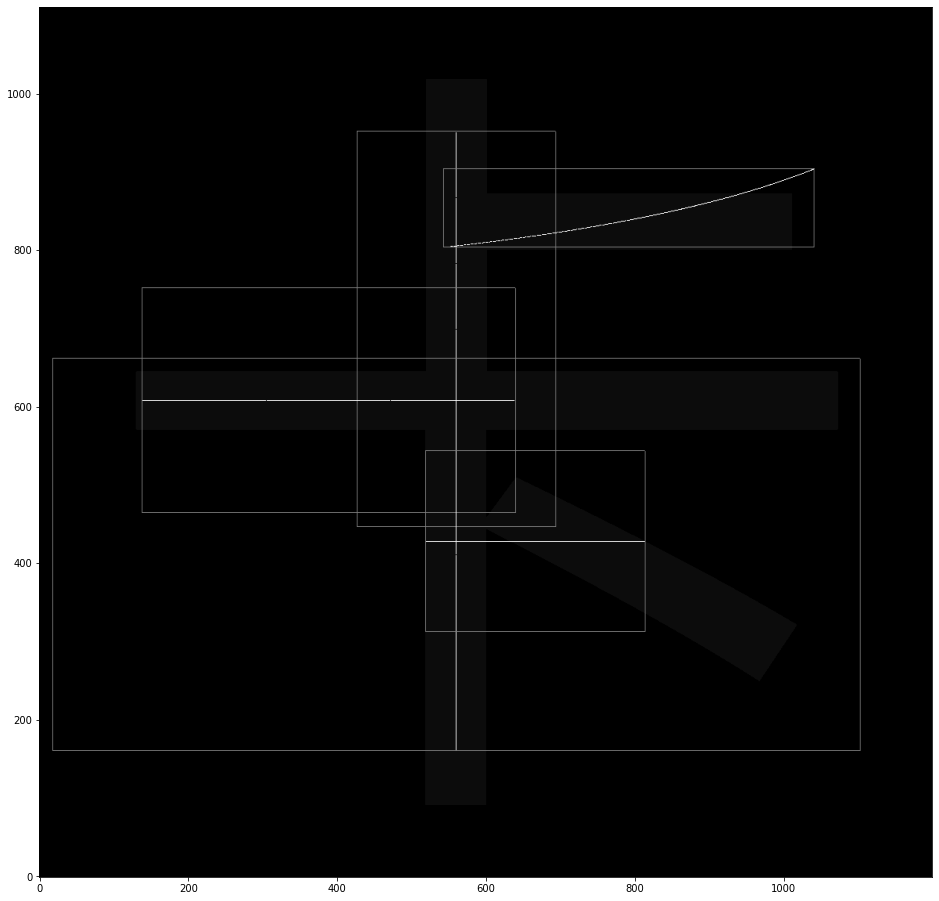

In [91]:
import Strokes as st

formalDict = st.loadFormalStrokes()

newFormalFits = []
for fit in formalFits:
    b = fit.bounds #bounding box
    stroke = formalDict[fit.type]
    strokeType = fit.type
    origBounds = np.array([b.minX, b.maxX, b.minY, b.maxY])
    params =  origBounds.copy()
    weights = [2,1,5,5] #perim, bound diff, distance score, aspect ratio

    print(params)
    
    sol = opt.minimize(errFunc, params, (origBounds, stroke, strokeType, distImg, weights), 
                       tol = 10e-7, method='Nelder-Mead')['x']
    print(sol, errFunc(params, origBounds, stroke, strokeType, distImg, weights))
    
    sol = sol.astype(int)
    newFit = st.StrokeMatch(fit.type, fit.style, 
                            st.BoundingBox([[sol[0],sol[1]],[sol[2],sol[3]]]))
    newFormalFits.append(newFit)
    
newFitImg = st.drawFormalFits(newFormalFits, charImg, drawBox=True)
fig, ax = plt.subplots(figsize=(16,16))
ax.imshow(newFitImg, origin='lower', cmap='gray', vmin=0, vmax=20, aspect='auto')

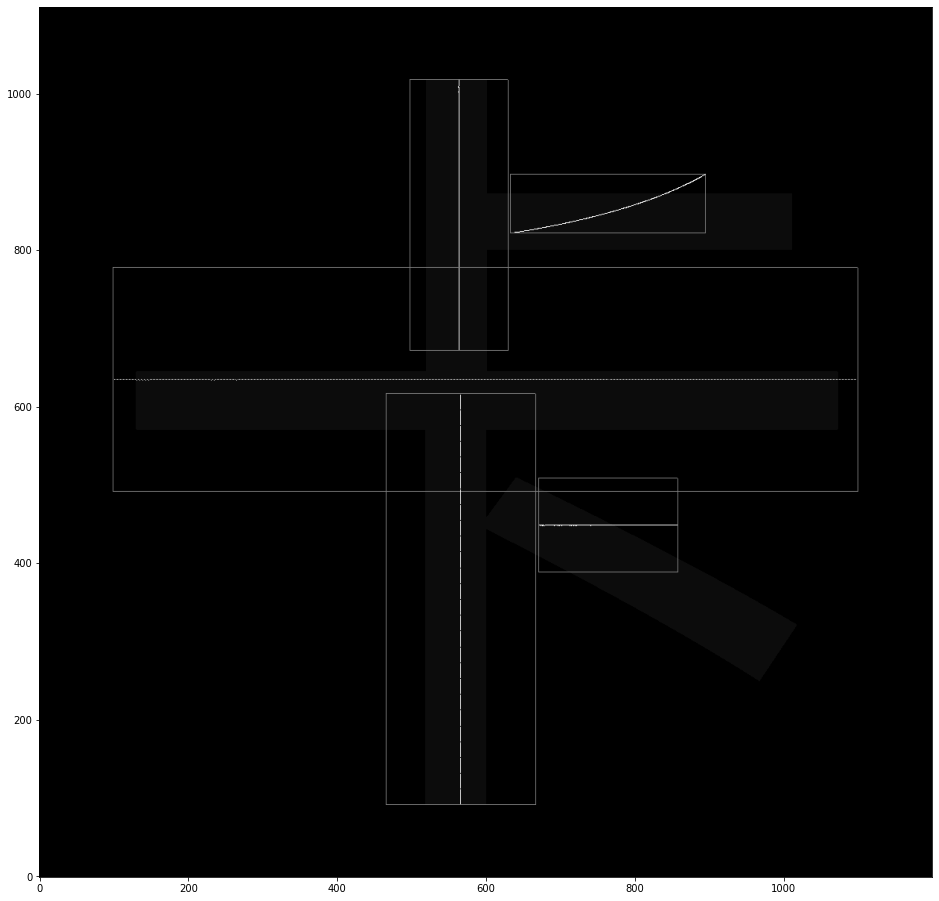

In [89]:
formalFitImg = st.drawFormalFits(formalFits, charImg)

fig, ax = plt.subplots(figsize=(16,16))

ax.imshow(formalFitImg, origin='lower', cmap='gray', vmin=0, vmax=20, aspect='auto')

## Export and Format properly
Export as an XML file, see examples.

In [12]:
sum(np.array([0,1,2,3])+np.array([0,1,2,-3]))

6

[690. 221.] (1111, 1200)
[359.0, 580.0, 127.0, 817.0]


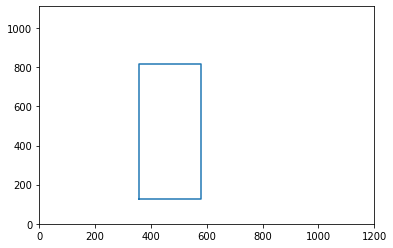

In [67]:
newShape = np.floor(np.random.rand(2)*np.shape(formalFitImg))
bLCoord = np.floor(np.random.rand(2)*(np.shape(formalFitImg) - newShape)) #bottom Left coordinates
bounds = [bLCoord[1], bLCoord[1]+newShape[1], bLCoord[0], bLCoord[0]+newShape[0]]

print(newShape, np.shape(formalFitImg))
print(bounds)

fig, ax = plt.subplots()

ax.set_ylim([0, np.shape(formalFitImg)[0]])
ax.set_xlim([0, np.shape(formalFitImg)[1]])

xCoords = [bounds[0], bounds[1], bounds[1], bounds[0], bounds[0]]
yCoords = [bounds[2], bounds[2], bounds[3], bounds[3], bounds[2]]

ax.plot(xCoords, yCoords)